# 25-26: 4369 -- PROGRAMMING FOR DATA ANALYTICS
## Big Project

<img src="./images/Programming.png" alt="programming" width="400">

One of the main challenges of this project (I found) was deciding on a suitable data subject to research and then attempting to **source** data.  
While I looked into data for Retail Sales, Traffic Accidents, Weather, etc (and browsing Kaggle for potential subjects) ... after several failed attempts, I found that *I needed a pursue a subject I was genuinely curious about.*  

I decided to look into the subject of **Trends in the use of Programming Languages** and to leverage the huge data repository of **GitHub** as a data source.  
  
I wanted to potentially look at the following Programming Language Trends
* Analyze which languages are growing/declining over time
* Analyze language switching patterns (Devs moving from language x to language y)
* Has the recent explosion of AI resulted in a rise of AI-related repositories 
    * How have these AI-related repositories grown in recent years
    * How does this growth compare with traditional languages
* Compare developer activity by geography and timezone
    * How does India and China compare with EU/US in github activity 
* Visualize the shift from older to newer languages


GitHub Data Sources are available in :  
* GitHub API - Free tier allows decent access  
* GH Archive - Historical GitHub event data (billions of events!)  
* GitHub's public datasets on Google BigQuery  
* Pre-made datasets on Kaggle  

I initially looked into the GitHub API as a mechanism to extract the datasets I would require.

***
## The GitHub REST API with Python
### (... and its limitations 😖)

I experimented a while with Python scripts that collect GitHub Metadata and save to CSV files.  
https://blog.apify.com/python-github-api/  
https://melaniesoek0120.medium.com/how-to-use-github-api-to-extract-data-with-python-bdc61106a501  

I also investigated the use of the PyGithub Library.   
https://github.com/PyGithub/PyGithub  
https://pygithub.readthedocs.io/en/latest/introduction.html  
https://stackoverflow.com/questions/10625190/most-suitable-python-library-for-github-api-v3  
https://www.youtube.com/watch?v=QaURSdmP0o8  

But, this only highlighted how restrictive this API's "Rate Limit" can be.  
Look at script below (generated with help of Claude AI) that uses pyGithub module to attempt to look at the count of language specific  repositories created with a specific period  

[My Python Script for Extracting Github Data](./testing/github_api_test.py)  
Note: To use the PyGithub Module you will need to install PyGithub library with  
`pip install PyGithub`  

If you look at the results of this script (output to [this text file](./testing/Github_REST_API_Results.txt)), all language for all months return exactly same result ... "1,000 repos"  
**I am obviously hitting a limit of some sort here.**
This is GitHub Search API’s “1,000-result cap”
   
A simplified version (with a hard-coded sample) is shown below where even a reduced time interval of only 3 hours is used...   
It still returns a count close to the limit of 1000 repositories   

*Experimentation with values for language, start_date, and end_date highlight how restrictive this 1000 limit is.*

In [53]:
from github import Github, RateLimitExceededException, Auth
from dotenv import load_dotenv
import pandas as pd
from datetime import datetime, timedelta
import time
import os

# Load environment variables from .env file
load_dotenv()

# Get the token from environment variables
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")


# Create authentication object
auth = Auth.Token(GITHUB_TOKEN)
# Initialize GitHub client with auth
g = Github(auth=auth)

# Verify authentication
try:
    user = g.get_user()
    print(f"Authenticated as: {user.login}")
except Exception as e:
    print(f"Authentication failed: {e}")

# Example usage 
language = 'Python'
start_date = '2024-03-01T00:00:00+00:00'
end_date = '2024-03-01T03:00:00+00:00'

# Build the API search query
query = f"language:{language} created:{start_date}..{end_date}"
# Search repositories with PyGithub
result = g.search_repositories(query=query)
# Get total count
total_count = result.totalCount
print(f"Count of {language} repos created between {start_date} and {end_date}: {total_count}")



Authenticated as: ngn73
Count of Python repos created between 2024-03-01T00:00:00+00:00 and 2024-03-01T03:00:00+00:00: 940


<font color="crimson">... **I needed to find an alternative (less restrictive) method to extracting Github Repository metadata.**</font>   

<font color="yellow">But, there are still some advantages to using the GitHub API where this limit is not applicable to extracting geo-based data (more on that later)</font>   

***
## Google BigQuery + GitHub Archive  
### (... and its paywall 😖)  

As a potential alternative to using the GitHub REST API (with Python), Google's Cloud-based Data Warehouse Service "BigQuery" provides a series of tools for extracting and analyzing large scale databases (sometimes billions of rows)   
BigQuery abstracts the complexity of underlying server/database infrastructure. You just load data and run standard SQL queries against it.  
https://console.cloud.google.com/bigquery/  
https://www.datacamp.com/tutorial/beginners-guide-to-bigquery  
https://www.udemy.com/course/introduction-to-google-cloud-bigquery/  <font color="crimson">*(requires subscription)</font>

More importantly, Google is also in collaboration with GitHub providing access to an incredible new Github Archive database via **Google BigQuery**  
The Google BigQuery Public Datasets program now offers a full snapshot of the content of more than 2.8 million open source GitHub repositories in BigQuery  
This provides a alternative mechanism to analyze the source code of almost 2 billion files with a simple (or complex) SQL query without the limitations experienced above.   
  

https://cloud.google.com/blog/topics/public-datasets/github-on-bigquery-analyze-all-the-open-source-code  
https://hoffa.medium.com/github-on-bigquery-analyze-all-the-code-b3576fd2b150  
https://hoffa.medium.com/400-000-github-repositories-1-billion-files-14-terabytes-of-code-spaces-or-tabs-7cfe0b5dd7fd  
https://github.com/fhoffa/analyzing_github?tab=readme-ov-file  

The use of SQL was ideal as I am quite comfortable with the SQL syntax  
https://docs.cloud.google.com/bigquery/docs/reference/rest?apix=true   
https://codelabs.developers.google.com/codelabs/bigquery-github#0  

There is a lot of menus within Google Cloud. Within Google Cloud, goto Navigation Menu -> BigQuery->Studio and select 'SQL Query'
<img src="../images/Goole_BigQuery_SQL.png" alt="Google BigQuery" width="600">  

**SQL queries within BigQuery can be used to structure, clean, and prepare the data so it meets the needs of my analysis   
Results can then be saved as CSV or JSon files for further processing/visualizing with Python.**  
  
The core tables to query against fall under 2 categories:  
1. "githubarchive" Time based activity Tables (examples below)
* **githubarchive.day.20241201** (Archive of events for day December 1, 2024)  
* **githubarchive.month.202411** (Archive of events for Month November 2024)  
* **githubarchive.year.2024** (Archive of events for Year 2024)  

To query the whole of 2024 you can also use a wildcard in the Table name (e.g. githubarchive.day.2024*)   

2. "github_repos" Snapshots of GitHub repository contents, metadata, commits, etc.
* **commits**
*  **files**
*  **contents**
*  **languages**
   
 



The details of each Gitub event (push, pull, create, frk, etc.) are stored within the "payload" field. The content of the "payload" field is different for each event type and may be updated by GitHub at any point, hence it is kept as a serialized JSON string value in BigQuery. JSON_EXTRACT functions can be used to apply filters to this Field  
  
https://www.gharchive.org/#:~:text=The%20content%20of%20the%20%22payload,access%20data%20in%20this%20field.  
https://github.com/igrigorik/gharchive.org/issues/148  
  
  
An example SQL script below filters 'pull' events for Python and Javascript languages using **JSON_EXTRACT_SCALAR( )**

```
SELECT 
    FORMAT_DATE('%Y-%m', PARSE_DATE('%y%m%d', _TABLE_SUFFIX)) as month,
    JSON_EXTRACT_SCALAR(payload, '$.pull_request.base.repo.language') as language,
    COUNT(*) as pr_count,
    COUNT(DISTINCT repo.name) as active_repos
FROM `githubarchive.day.20*`
WHERE 
    type = 'PullRequestEvent'
    AND JSON_EXTRACT_SCALAR(payload, '$.pull_request.base.repo.language') IN ('Python', 'JavaScript')
    AND _TABLE_SUFFIX BETWEEN 
        FORMAT_DATE('%y%m%d', DATE_SUB(CURRENT_DATE(), INTERVAL 6 MONTH))
        AND FORMAT_DATE('%y%m%d', CURRENT_DATE())
GROUP BY month, language
ORDER BY month DESC, pr_count DESC;
```


It could also be argued that the full data analysis could be performed completely within the BigQuery Studio as it offers a wide range of advanced tools for Analysis.  
But, in the interest of displaying the use of a range of tools covered in Module *25-26: 4369 -- Programming for Data Analytics* with an emphasis on Python, I will export datasets from BigQuery as CSV/JSon and later process with Python code.

Python can integrate with BigQuery Datasources with the **google-cloud-bigquery** package.  
https://docs.cloud.google.com/python/docs/reference/bigquery/latest  
This will require the Setup of authentication that will require additional configuration (application credentials, project_id, etc.).  
But, in the interests of migrating code other machines (and allowing code to be potentially tested by Andrew), I would definitely be better off using the BigQuery console directly for simpler, manual exports of SQL Data Resultsets (into CSV or JSon format)  
  
**I had planned to use the BigQuery console directly to generate CSV or JSon result Files that will act as the Data-source my Analysis Project.**  
While I was using the "free tier" of BigQuery and I was assured by AI that I would not encounter limits, I quickly encountered a very expensive Paywall.  
I had planned to use BigData to generate small-sized files that would be nowhere near a GB in size.   
But, this "free tier" of BigQuery also limits the amount of *data you can query* against. The free tier allows up to 1 Terabyte (TB)  of Table searches (query data) ... **My Queries were searching thru sometimes 4TB of data** 😲   ... and I quickly hit a paywall !
***

# Using the GH Archive  
### (... and its unmanageable size 😖)    

This a archive of .json.gz files.  
It is free, has no rate limits, and has a complete history of activity starting from 2011.  
  
https://www.gharchive.org  

Zipped Json files are downloaded from this archive via constructed URL's  :   
`https://data.gharchive.org/[Year]-[Month]-[day]-[Hour].json.gz`  
For example :  
* Activity for 15/11/2024 @ 4PM UTC	:  https://data.gharchive.org/2024-11-15-16.json.gz
* Activity for 11/09/2022	:  https://data.gharchive.org/2022-09-11-{0..23}.json.gz
* Activity for all of January 2023	: https://data.gharchive.org/2023-01-{01..31}-{0..23}.json.gz
* Activity for all of 2021	: https://data.gharchive.org/2021-{01..12}-{01..31}-{0..23}.json.gz

Attempts at manually downloading data from data.gharchive.org showed how large these files actually were.  
Files can be 4–6 GB (compressed) per month, and 60–120 GB (uncompressed)  
**These were unmanageable large files.**  

This GH Archive can integrate with Python via the **gharchive** Library :  
https://nickderobertis.github.io/py-gh-archive/

I investigated if these data files could be filtered to reduce the payload of data downloaded.  

Below is python sample code that reads GitHub Activity for the popular repository 'torvalds/linux' between 2 dates

In [54]:
from datetime import datetime, timedelta
from gharchive import GHArchive
import pandas as pd

gh = GHArchive()

def save_to_file(df, filename, format='csv'):
    """Save DataFrame to file"""
    if df.empty:
        print("No data to save")
        return
    
    if format == 'csv':
        df.to_csv(filename, index=False)
    elif format == 'json':
        df.to_json(filename, orient='records', indent=2)
    elif format == 'parquet':
        df.to_parquet(filename, index=False)
    
    print(f"\nSaved {len(df)} events to {filename}")

start = datetime(2017, 8, 19, 9, 0)  # 19/08/2017 09:00 AM
end = datetime(2017, 8, 19, 17, 0)    #  19/08/2017 05:00 PM

#Extract events for dates and filtered by the 'torvalds/linux' repository
data = gh.get(start, end, filters=[('repo.name', 'torvalds/linux')] )

# Convert Archive Object to DataFrame
df = data.to_df()

#Save to a CSV file
save_to_file(df, 'github_events.csv', format='csv')


Saved 17 events to github_events.csv



After a bit of experimentation with scripts, I found that it downloads the entire hour(s) of GH Archive ... and then filters Locally in Python.  
GHArchive.get() downloads  EVERYTHING and Loads in Memory.   
This is not what I need ... if I intend to query/analyze multiple years of GitHub data, the downloads would be unmanageable. 

***

**<font color="crimson">Lessons were learned here !</font>**  
According to internet sources ...   
## <font color="lightblue">"GitHub activity datasets are some of the hardest to work with at scale because they’re huge, rate-limited, and fragmented."</font>

But, I spent so much time committing to this project plan ... I am determined to deliver 0something related to GitHub repositories.  
**I had to take a week or two break from this project to work on assignments and projects for other Modules**  

As a final last ditch approach I will use Kaggle datasets (the most approachable option).   
It does mean initial plans for this project is no longer viable, and I need to downsize my original project requirements.   

... Again, this has only made me more determined not to have to abandon this "GitHub" subject matter for (let's say) your recommended default  project of "Knock Weather" ... and deliver some form of (albeit downsized) analysis of GitHub based activity for this project.  

I need to do a study on historical trends in programming languages using GitHub datasets. 
* I cannot use the GitHub API (too restrictive) 
* I cannot use Google BigQuery (too expensive a paywall) 
* I cannot use GHArchive (files too large) 

**I need to use Kaggle data files (CSV, JSON,Parquet) to study historical trends in programming languages**

***

# Kaggle GitHub Datasets  
The use of file-based Kaggle datasets avoid the API rate limits, BigQuery scan costs, and massive GH Archive downloads.  
I searched thru [Kaggle](https://www.kaggle.com) datasets for GitHub related Data, and found the following CVS and JSON Datasets  

These datasets were sourced from the very sources I failed to use (API, BigQuery, and GH Archive)

A Large-Scale Dataset of Popular OSS Projects (Muna AL)   
https://www.kaggle.com/datasets/muname/github-repos-mainlang  
  
GitHub Repository Metadata  
https://www.kaggle.com/datasets/isaacoresanya/github-repository-metadata  

GitHub Programming Languages Data (Isaac Wen)   
https://www.kaggle.com/datasets/isaacwen/github-programming-languages-data?select=repos.csv  

GitHub Dataset  (Nikhil Raj)  
https://www.kaggle.com/datasets/nikhil25803/github-dataset?select=repository_data.csv  

github-snippets (whynothacked)  
https://www.kaggle.com/datasets/rootedperson/github-snippets?select=snippets.jsonl  

Programming Languages (Sujay Kapadnis)  
https://www.kaggle.com/datasets/sujaykapadnis/programming-languages

GitHub Repository Metadata  (IsaacOresanya)  
https://www.kaggle.com/datasets/isaacoresanya/github-repository-metadata  

***
# Analysis of Most Popular Programming Languages

To kick-off this analysis of Trends in Programming Languages activity on GitHub, I'll start with the most basic of the above listed Datasets:  
Isaac Wen's "github-programming-languages-data" dataset.  

There are 2 files in this dataset.  
**repos.csv** is a simple 2 column CSV file that lists the number of Repo's for 435 unique Programming Languages from  the years 2011 to 2021.  
**prs.csv** is a 4 column files containing information for the number of PULL Requests for each language, sorted by year, and quarter of the year from  the years 2011 to 2021.  

The Dataset are small, require no cleaning, and data is very focused on counts  

In [55]:
# View top 10 rows of repos.csv

import pandas as pd

df = pd.read_csv("./data/github-programming-languages-data/repos.csv")
print(df.head(25))
print(df.columns)

        language  num_repos
0     JavaScript    1100421
1            CSS     813443
2           HTML     779549
3          Shell     638068
4         Python     548870
5           Ruby     374802
6           Java     369282
7            PHP     339901
8              C     292000
9            C++     278066
10      Makefile     249563
11   Objective-C     168007
12            C#     133013
13          Perl     101450
14     Batchfile      97450
15            Go      91119
16    ApacheConf      68849
17  CoffeeScript      68833
18         CMake      55874
19      Assembly      47560
20    TypeScript      46332
21         Swift      42372
22         Scala      34501
23           Lua      34089
24           ASP      33386
Index(['language', 'num_repos'], dtype='object')


Lets use this data file to generate a Bar Chart of Repository Numbers by Programming Language 2011 - 2021

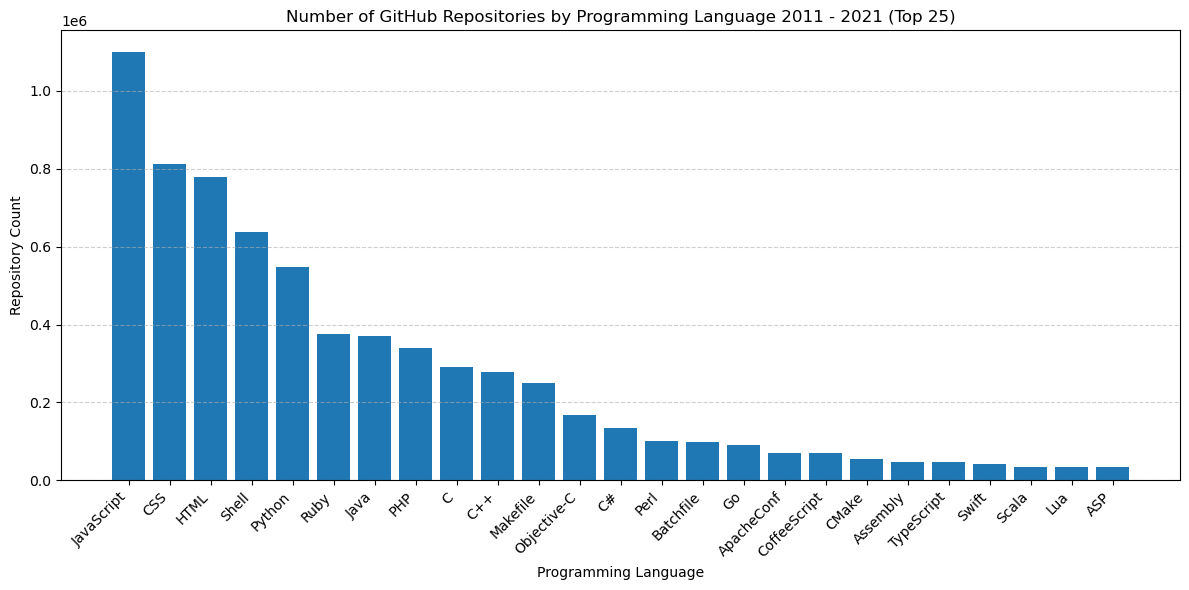

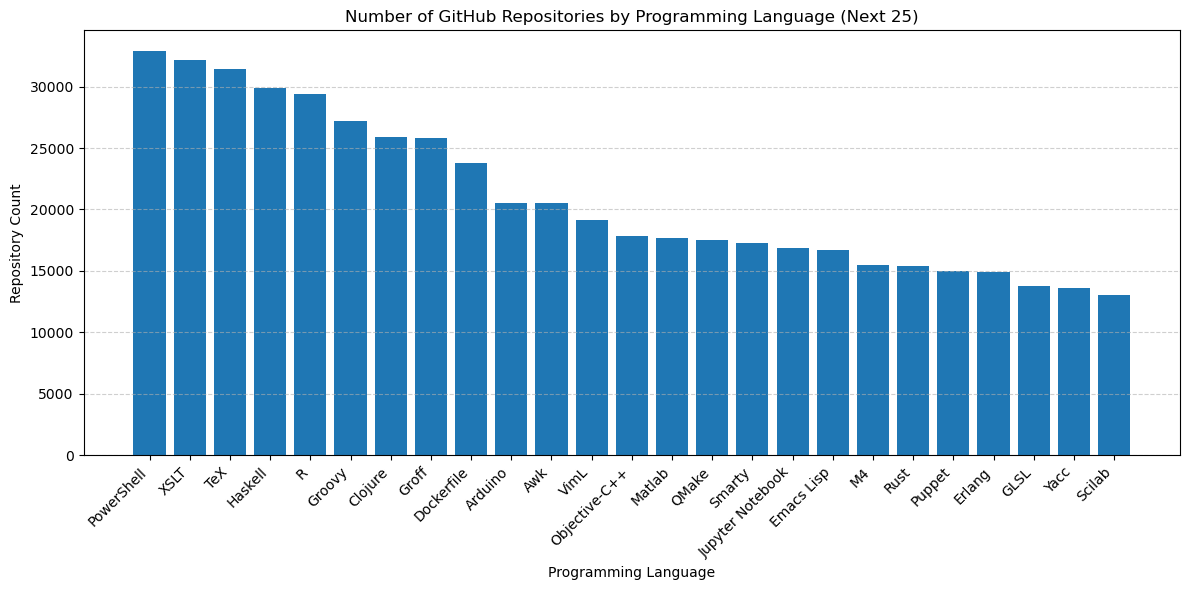

In [56]:
#*************************************************************************
# Bar Chart Visualization of GitHub Repositories by Programming Language
# using repos.csv data file
#*************************************************************************

import pandas as pd
import matplotlib.pyplot as plt

# Load local csv data
df = pd.read_csv("./data/github-programming-languages-data/repos.csv")

# Sort by repo count (descending)
df = df.sort_values("num_repos", ascending=False)

# Select top 25 and next 25 languages
sample_n = 25
df_top1 = df.iloc[:sample_n]
df_top2 = df.iloc[sample_n:(sample_n * 2)]



def plot_bar_chart(df, title):
    plt.figure(figsize=(12, 6))
    plt.bar(df["language"], df["num_repos"])
    plt.xticks(rotation=45, ha="right")
    plt.title(title)
    plt.xlabel("Programming Language")
    plt.ylabel("Repository Count")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot (top 25 languages)
plot_bar_chart(df_top1, "Number of GitHub Repositories by Programming Language 2011 - 2021 (Top 25)")
# Plot (next 25 languages)
plot_bar_chart(df_top2, "Number of GitHub Repositories by Programming Language (Next 25)")

plt.show()

Lets look at other file **prs.csv** to view number of *pull requests* 2011-2021 (quarterly) 

In [57]:
#*************************************************************************
# Line Plot Visualization of GitHub Pull Requests by Programming Language
# using prs.csv data file
#*************************************************************************

import pandas as pd

prs = pd.read_csv("./data/github-programming-languages-data/prs.csv")




#extract the top 10 languages by total PR count (for all years)
#25 Languages too many to visualize clearly
top_languages = (
    prs.groupby("name")["count"]
       .sum()
       .sort_values(ascending=False)
       .head(10)
       .index
) 

prs_top = prs[prs["name"].isin(top_languages)]
quarter_to_month = {1: 1, 2: 4, 3: 7, 4: 10}


prs_top["date"] = pd.to_datetime(
    dict(
        year=prs_top["year"],
        month=prs_top["quarter"].map(quarter_to_month),
        day=1
    )
)

#Need to filter out outlier data outside date range (2012 -2021)
start_date = pd.Timestamp("2012-01-01")
end_date   = pd.Timestamp("2021-10-01")
prs_filtered = prs_top[
    (prs_top["date"] >= start_date) &
    (prs_top["date"] <= end_date)
]

#Pivot table to summarize PR counts by date and 10 languages
prs_pivot = prs_filtered.pivot_table(
    index="date",
    columns="name",
    values="count",
    aggfunc="sum"
).sort_index()


print(prs_pivot)

name           C#    C++      Go   HTML    Java  JavaScript     PHP  Python  \
date                                                                          
2012-01-01   1551   4942     298    343    7817       13388   17274   15692   
2012-04-01   1833   4423     313   1097    7183       15668   14324   14656   
2012-07-01   1887   4894     543   1402    8285       19104   17240   17288   
2012-10-01   2379   5861     858   1790   10964       21190   17308   21675   
2013-01-01   3665   7240    1341   2819   16919       32666   23628   29487   
2013-04-01   4497   9943    2318   3897   17650       37471   25522   38044   
2013-07-01   5074  11878    3584   4455   22139       46079   28573   44783   
2013-10-01   7461  15174    5050   7378   29410       58732   35335   54051   
2014-01-01   7955  20710    6673   9175   35787       79285   46231   65225   
2014-04-01  10549  24380   10016  13161   43988       91650   46812   73924   
2014-07-01  11871  29235   16910  16756   49765     

C:\Users\Niall\AppData\Local\Temp\ipykernel_7080\1083564306.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prs_top["date"] = pd.to_datetime(


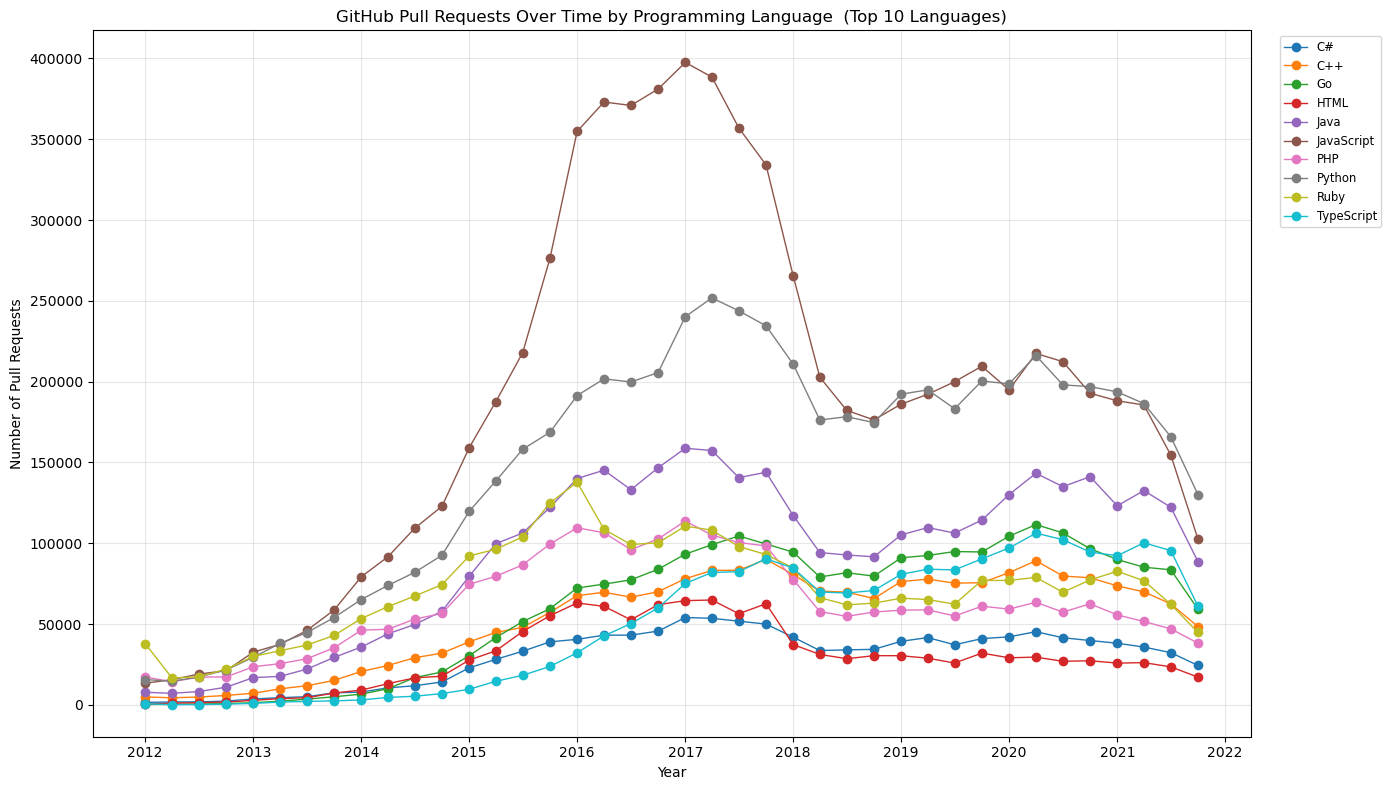

In [58]:

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
for language in prs_pivot.columns:
    plt.plot(
        prs_pivot.index,
        prs_pivot[language],
        label=language,
        linewidth=1,
        marker='o'
    )

plt.title("GitHub Pull Requests Over Time by Programming Language  (Top 10 Languages)")
plt.xlabel("Year")
plt.ylabel("Number of Pull Requests")
plt.legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    fontsize="small",
    ncol=1
)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


# Observations on GitHub Language Trends  


**Javascript** is by far the most popular Language
1. It runs everywhere (runs on all browsers, app platforms, enterprise systems)  
2. One language, full stack (frontend + backend)  
3. Ecosystem (JavaScript has the largest package ecosystem in the world)  
4. Low barrier to entry (easy to start)  

**Python** is the close second in popularity. 
Python proves to be very resourceful in areas of Data science & analytics, Automation, AI/ML, and DevOps

https://chatgpt.com/share/694a7ab3-e610-8001-8752-d3c7450b00b7  
https://medium.com/@trienpont/5-reasons-why-javascript-is-the-worlds-most-popular-programming-language-a0915bc39060  
https://www.youtube.com/watch?v=yi1045xWzPQ  
https://thecodest.co/en/dictionary/why-is-javascript-so-popular/  


There was a very obvious peak in GitHub activity in the period 2016 - 2018  
There are multiple factors that contributed to this peak in activity during this period  
Pull request behaviour changed after 2018 (fewer PRs -- more code updated)

The Pandemic
https://www.govtech.com/analytics/github-data-shows-how-pandemic-changed-work-schedules  
https://www.researchgate.net/publication/374564676_Analyzing_the_Impact_of_COVID-19_on_GitHub_Event_Trends  



***
# Analyzing (newly created) Large-Scale Projects
So far we have used **isaacwen/github-programming-languages-data** → prs.csv and pepo.csv files to look at  
* Number of language specific Repos (Adoption & popularity) 
* Pull Request activity  (Collaboration & activity)  

This analysis addresses the question : “Which languages generate the most collaborative activity?”

We now need to strengthen this study with a look at activity in Large Scale Open-Source Projects.  
With this approach we use the Kaggle dataset by Muna AL : "A Large-Scale Dataset of Popular OSS Projects"  
https://www.kaggle.com/datasets/muname/github-repos-mainlang  

This dataset is defined as:
A dataset where a primary language can be identified (primary language = 95% of the total code base)

The dataset contributor examined the most popular 15,000 repositories on GitHub, as indicated by ratings (stars) from January 2012 to December 2017. The selected projects had the following characteristics:

* The project should have a main language, which makes up 95% of the total project’s code.
* The project should have at least 500 stars.
* The main language should be a high-level, and general-purpose one.
* The repository should not have a reportedly infinite number of contributors and/or commits by Github.
* There should be at least 60 projects per language for it to be considered for the dataset.    

Each row in data file is a unique repository of a large-sale OSS.  
This data is ideal for analyzing language adoption as opposed to contribution activity. We should be able to see growth patterns emerge for the newer languages.


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from datetime import datetime

# Need to analyse data per Quarter ... Calculate the first month of the quarter
def year_quarter_to_date(year, quarter):
    month = (quarter - 1) * 3 + 1  
    str_date = f"{year}-{str(month).zfill(2)}-01" 
    return datetime.strptime(str_date, '%Y-%m-%d').date()

#Load CSV data
df_muna = pd.read_csv("./data/A Large-Scale Dataset of Popular OSS Projects/DatasetDataKaggle.csv")


# Get the distinct list of programming languages
print("Distinct Programming Languages in Dataset:")
distinct_languages = df_muna['Primary Language'].unique()

# Process dataset to extract Quarter date for "created_at" date
df_muna =   df_muna[["Primary Language", "created_at"]].dropna()
df_muna["created_at"] = pd.to_datetime(df_muna["created_at"], errors="coerce")
df_muna = df_muna.dropna(subset=["created_at"])
df_muna["year"] = df_muna["created_at"].dt.year
df_muna["quarter"] = df_muna["created_at"].dt.quarter
df_muna["year_quarter"] = df_muna.apply(lambda row: year_quarter_to_date(row["year"], row["quarter"]), axis=1)

# Count number of Repos for each Language (for each quarter) = repo_count
repos_by_year = (
    df_muna.groupby(["year_quarter", "Primary Language"])
      .size()
      .reset_index(name="repo_count")
)

# Sort 11 languages by total repo count (all years) 
top_languages = (
    repos_by_year.groupby("Primary Language")["repo_count"]
    .sum()
    .sort_values(ascending=False)
    .index
)

repos_top = repos_by_year[repos_by_year["Primary Language"].isin(top_languages)]

# Pivot the Table to horizontally list repo counts for each language
repos_pivot = repos_top.pivot_table(
    index="year_quarter",
    columns="Primary Language",
    values="repo_count",
    aggfunc="sum"
).sort_index()

print(repos_pivot.tail(10))

Distinct Programming Languages in Dataset:
Primary Language    C   C#  C++    Go  Java  JavaScript  Objective-C   PHP  \
year_quarter                                                                 
2015-07-01        2.0  5.0  4.0  17.0  87.0        69.0         18.0  11.0   
2015-10-01        2.0  4.0  2.0  17.0  87.0        66.0         14.0   5.0   
2016-01-01        1.0  4.0  5.0  22.0  76.0        59.0          5.0   6.0   
2016-04-01        2.0  4.0  3.0  14.0  69.0        50.0         10.0   8.0   
2016-07-01        3.0  6.0  2.0  16.0  64.0        47.0          5.0   4.0   
2016-10-01        2.0  3.0  2.0  15.0  59.0        50.0          3.0   1.0   
2017-01-01        1.0  1.0  1.0  16.0  52.0        46.0          4.0   1.0   
2017-04-01        1.0  1.0  3.0  14.0  30.0        33.0          2.0   NaN   
2017-07-01        NaN  1.0  5.0   8.0  12.0        35.0          NaN   1.0   
2017-10-01        NaN  NaN  1.0   2.0   3.0        16.0          1.0   NaN   

Primary Language  Py

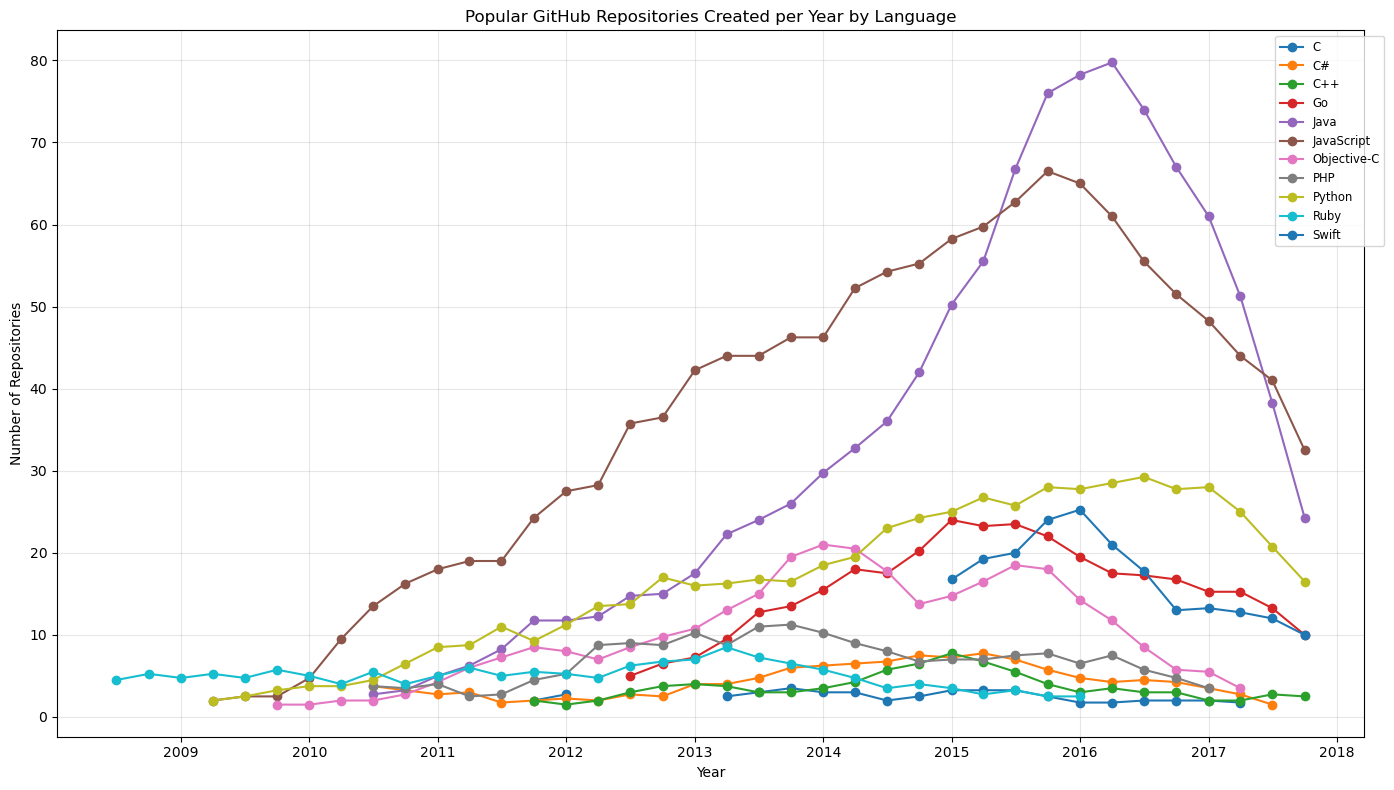

In [ ]:
import matplotlib.pyplot as plt

# Calculate rolling average for each language (otherwise a bit erratic)
# Plot of repo counts per year ( as opposed to Quarter) was less erratic ... but I wanted the additional data
repos_pivot_rolling = repos_pivot.rolling(window=4).mean()

plt.figure(figsize=(14, 8))

for lang in repos_pivot_rolling.columns:
    plt.plot(
        repos_pivot_rolling.index,
        repos_pivot_rolling[lang],
        label=lang,
        linewidth=1.5,
        marker = 'o'
    )

plt.title("Popular GitHub Repositories Created per Quarter by Language")
plt.xlabel("Year")
plt.ylabel("Number of Repositories")
plt.grid(True, alpha=0.3)
plt.legend(
    loc="upper right",
    bbox_to_anchor=(1.02, 1),
    fontsize="small"
)
plt.tight_layout()
plt.show()

***
# Linear Regression of Trends  

To simplify the comparative trends between each language, we can use *Linear Regression* to quantify the relationship between the Repo Count and Year.  
It is calculated with the formula :

${Count_{t}} =  \alpha + \beta \cdot t $  
Where:  
𝑡 = year (or index)  
𝛽 = absolute change per year  

In [70]:


def slope_per_year(s):
    s = s.dropna()
    if len(s) < 2: 
        return np.nan
    X = s.index.values.reshape(-1,1)
    y = s.values
    model = LinearRegression().fit(X, y)
    return model.coef_[0]

lr_slopes = repos_pivot.apply(slope_per_year, axis=0)
#sort by most positive regression slope
lr_slopes = lr_slopes.sort_values(ascending=False)
print("Linear Regression Slope of Repositories Created by Language:")
print((lr_slopes))

TypeError: float() argument must be a string or a real number, not 'datetime.date'

***
# Compund Annual Growth Rate (CAGR)
Compound Annual Growth Rate (CAGR) is a widely used financial metric that measures a financial investment's annual growth rate over a specific period.  
https://www.datacamp.com/tutorial/cagr-excel-formula  
https://www.geeksforgeeks.org/finance/compound-annual-growth-rate-cagr-formula-calculation-uses/  

This financial metric can be applied to above OSS langugae data to provide a non-visual measure of the *momentum* of adaption of languages.  
**It can be used to numerically compare Language adaption trends.**  

Computing CAGR for a Language:  
$ CAGR = \left(\frac{V_{end}}{V_{start}}\right)^{\frac{1}{n}} - 1 $  
  
  Where:  
${V_{start}}$ = repos in first year  
${V_{end}}$ = repos in last year  
𝑛 = number of years between them  
  
  Below I pass each series (column) to a function that calculates the CAGR


In [71]:
def cagr_from_series(s: pd.Series) -> float:
    s = s.dropna()
    if len(s) < 2:
        return np.nan
    start_year = s.index.min()
    end_year = s.index.max()
    start_val = s.loc[start_year]
    end_val = s.loc[end_year]
    n_years = end_year - start_year
    if n_years <= 0 or start_val <= 0 or end_val <= 0:
        return np.nan
    return (end_val / start_val) ** (1 / n_years) - 1


cagr_by_lang = repos_pivot.apply(cagr_from_series, axis=0)
#sort by most positive CAGR
cagr_by_lang = cagr_by_lang.sort_values(ascending=False)
print("Compund Annual Growth Rate (CAGR) % of Repositories Created by Language:")
print((cagr_by_lang * 100).round(2).astype(str) + "%")


TypeError: '<=' not supported between instances of 'datetime.timedelta' and 'int'

# Ranking Growth

In [ ]:
df_rank = prs_pivot.rank(
    axis=1,
    method="min",
    ascending=False
)

rank_change = (
    df_rank.iloc[-1] - df_rank.iloc[0]
).sort_values()

avg_rank = df_rank.mean().sort_values()

print(avg_rank)

name
JavaScript    1.375
Python        1.875
Java          3.625
Ruby          4.675
PHP           5.825
Go            6.075
C++           6.325
TypeScript    7.650
C#            8.700
HTML          8.875
dtype: float64
